In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your data into a pandas DataFrame
data = pd.read_csv('../../data/balanced_classification_dataset.csv')  # replace 'your_dataset.csv' with your actual file

In [2]:
data = data.rename(columns={'data': 'text'})
data.head()

,Unnamed: 0.1,Unnamed: 0,patientid,sex,age,ANA,EXA,DIA_text,DIA_code,OP_text,OP_code,label,text
0,0,1,61.0,male,32.0,Beschwerden re. Achillessehne. NMR unauffällig...,Re. Achillessehne: Verdickung im Bereich der A...,Retropatellare Chondromalazie li; Insertionste...,M22.4,NaN,NaN,other,Beschwerden re. Achillessehne. NMR unauffällig...
1,1,2,67.0,male,41.0,Seit mehreren Monaten Beschwerden re. Achilles...,Re. Achillessehne: Deutliche Auftreibung der A...,V.a.laterale Chondromalazie bei st.n. Außenmen...,M23.3,NaN,NaN,meniskus_urgent,Seit mehreren Monaten Beschwerden re. Achilles...
2,2,6,72.0,male,19.0,. .Gestern beim Training stechende Schmerzen l...,Klinischer Befund des Oberschenkels li.deutl.V...,Z.n.arthroskopischer Chirurgie des Kniegelenkes.,M23.3,NaN,NaN,meniskus_urgent,. .Gestern beim Training stechende Schmerzen l...
3,3,7,72.0,male,23.0,beide Knie Schmerzen bei Treppe steigen oder L...,bd. Knie: frei Bewegl.; Patella o.B.; keine MZ...,Z.n.IM-Teilresektion re.,S83.2,NaN,NaN,meniskus_urgent,beide Knie Schmerzen bei Treppe steigen oder L...
4,4,9,84.0,male,57.0,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...,Klinischer Befund des Kniegelenks li.: Drucksc...,Beginnende Gonarthrose bds. li. mehr als re.,M17.9,NaN,NaN,other,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...


In [3]:
# Assuming you have two columns: 'text' and 'label'
texts = data['text'].values
labels = data['label'].values

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42
)

In [4]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("GerMedBERT/medbert-512")

# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding='max_length', max_length=400)

In [5]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)

2024-07-22 16:46:51.052147: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-22 16:46:51.052173: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-22 16:46:51.052177: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-22 16:46:51.052189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-22 16:46:51.052199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained("GerMedBERT/medbert-512", num_labels=len(label_encoder.classes_))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [8]:
# Train the model
# f1_2 with 128
# f1 was with 64
# just bert with 32
model.fit(train_dataset.shuffle(1000).batch(64),
          epochs=3,
          batch_size=32)


Epoch 1/3


2024-07-22 16:47:19.874451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


566/566 [==============================] - 2800s 5s/step - loss: 1.0431 - accuracy: 0.5825
Epoch 2/3
566/566 [==============================] - 2656s 5s/step - loss: 0.9261 - accuracy: 0.6447
Epoch 3/3
566/566 [==============================] - 2690s 5s/step - loss: 0.8656 - accuracy: 0.6707


In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

283/283 [==============================] - 172s 599ms/step - loss: 0.9826 - accuracy: 0.6240
Loss: 0.982631266117096
Accuracy: 0.6239504814147949


In [10]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

283/283 [==============================] - 177s 618ms/step


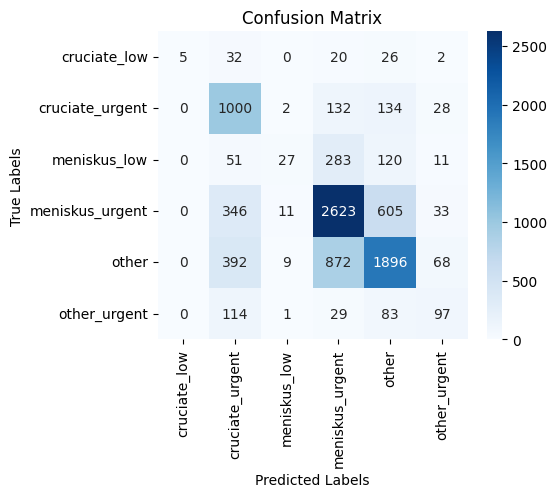

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                 precision    recall  f1-score   support

   cruciate_low       1.00      0.06      0.11        85
cruciate_urgent       0.52      0.77      0.62      1296
   meniskus_low       0.54      0.05      0.10       492
meniskus_urgent       0.66      0.72      0.69      3618
          other       0.66      0.59      0.62      3237
   other_urgent       0.41      0.30      0.34       324

       accuracy                           0.62      9052
      macro avg       0.63      0.42      0.41      9052
   weighted avg       0.63      0.62      0.61      9052



In [13]:
model.save_pretrained('german_bert_classify_model_f1_2')  # replace with your desired path
tokenizer.save_pretrained('german_bert_classify_tokenizer_f1_2')  # replace with your desired path

('german_bert_classify_tokenizer_f1_2/tokenizer_config.json',
 'german_bert_classify_tokenizer_f1_2/special_tokens_map.json',
 'german_bert_classify_tokenizer_f1_2/vocab.txt',
 'german_bert_classify_tokenizer_f1_2/added_tokens.json')